In [7]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import *
from fastai.callback.tracker import *
from fastai.callback.tensorboard import *
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

from torch.utils.tensorboard import SummaryWriter  

In [8]:
writer = SummaryWriter('vunet/log')

## Define Dataset

In [9]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=8, steps=4)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=8, steps=4)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=8, steps=4)

In [10]:
batch_size = 8
device = 'cuda'
folder_to_save_models = 'weights_32-32_epoch100'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [11]:
from vunet_model import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=8)

## Build Learner

In [12]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard], model_dir=folder_to_save_models, cbs=CSVLogger)

In [13]:
learn.summary()

Net1 (Input shape: 8 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

## Training

### Training for 50 epoches

In [14]:
# learn.lr_find()

In [15]:
learn.fit(100, lr=2e-4, cbs=[CSVLogger, EarlyStoppingCallback(monitor='valid_loss', patience=15), SaveModelCallback(every_epoch=2)])

epoch,train_loss,valid_loss,valid_leaderboard,time
0,978.483948,28.757212,0.008382,06:32
1,273.409210,5.145169,0.004137,06:48
2,63.200172,2.185032,0.004855,06:12
3,31.289055,1.861681,0.001986,06:19
4,20.325788,1.361799,0.002109,06:22
5,12.904064,1.120660,0.001573,06:17
6,7.411152,1.094659,0.001744,06:11
7,4.179143,0.542133,0.001080,06:12
8,2.189765,0.362427,0.001734,06:11
9,1.109826,0.247272,0.004807,06:36


### fit_cycles

In [11]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,82.518250,6.059697,0.002984,0.002984,37:04
1,29.296463,0.066423,0.002888,0.002888,36:28


In [12]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

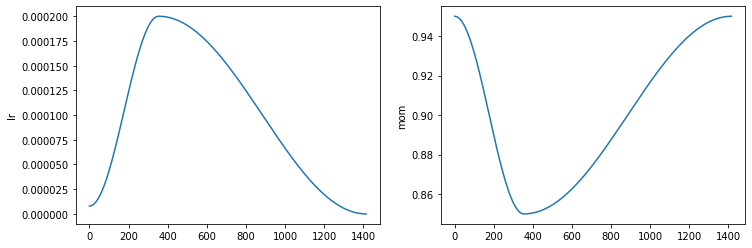

In [13]:
learn.recorder.plot_sched()

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.322788,0.317486,0.004964,0.004964,36:16
1,0.223381,0.004076,0.002363,0.002363,36:13


In [15]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [16]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.125142,0.052664,0.003794,0.003794,40:49
1,0.037557,0.002450,0.002057,0.002057,39:27


In [17]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [18]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.064689,0.022935,0.001123,0.001123,40:20
1,0.022693,0.002279,0.001968,0.001968,43:00


In [19]:
learn.save('Comb_8')

Path('weights/Comb_8.pth')

## Testing

In [10]:
learn.load('model_14')

/home/featurize/work/.local/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [11]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [12]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
pred = preds[0][0].cpu().detach().numpy()
print(pred.shape)

(8, 256, 256)


In [13]:
label = y[0].cpu().detach().numpy()
print(label.shape)

(8, 256, 256)


In [14]:
input = x[0].cpu().detach().numpy()

In [15]:
pred = recover(pred, 17, 32)
label = recover(label, 17, 32)
input = recover(input, 17, 32)

In [16]:
print(pred[:,0,0])
print(label[:,0,0])

[22.529928 21.051567 21.830782 22.386465 22.251034 22.84109  22.133858
 22.11602 ]
[22.51   22.6175 22.69   22.6375 22.7575 22.7    22.9175 22.6075]


In [17]:
diff = abs(pred - label)
print(diff)

[[[0.01992798 0.25196648 0.26356316 ... 0.18263626 0.5498314  1.2128487 ]
  [1.2073784  0.18740082 0.5255127  ... 0.53461075 0.21578026 0.6300278 ]
  [1.174469   0.03849411 0.21891975 ... 0.76566696 0.64660454 1.1328201 ]
  ...
  [1.335762   0.97343254 0.2889328  ... 0.06014252 0.04944229 0.03022194]
  [1.4341984  1.3802223  1.1627407  ... 0.26537895 0.7706909  0.54174614]
  [2.6984406  1.5824528  1.2938957  ... 0.3519783  0.5784073  1.257328  ]]

 [[1.5659332  0.07390594 0.09872246 ... 0.25932693 0.2894764  0.3471241 ]
  [0.5618057  0.30685043 0.35821152 ... 0.26011467 0.30652046 0.14073944]
  [0.26964378 0.51491547 0.51049614 ... 0.10992813 0.3278656  0.08139038]
  ...
  [2.0285797  1.3304863  0.7023792  ... 0.22018242 0.26079178 0.7749748 ]
  [2.38912    1.1571712  0.77077675 ... 0.279562   0.6483898  0.804451  ]
  [3.9777756  2.7637157  1.0137768  ... 0.41065407 0.6475811  2.753851  ]]

 [[0.8592186  0.30827522 0.2058239  ... 0.89264107 0.02095413 0.8862591 ]
  [0.13328743 0.817239

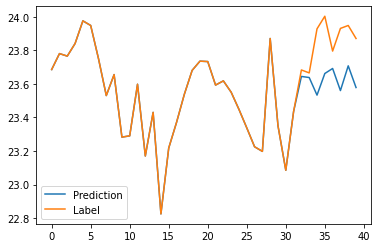

In [25]:
idx = [10, 120]
plt.plot(concat(input[...,idx[0], idx[1]], pred[...,idx[0], idx[1]]))
plt.plot(concat(input[...,idx[0], idx[1]], label[...,idx[0], idx[1]]))
plt.legend(['Prediction', 'Label'])

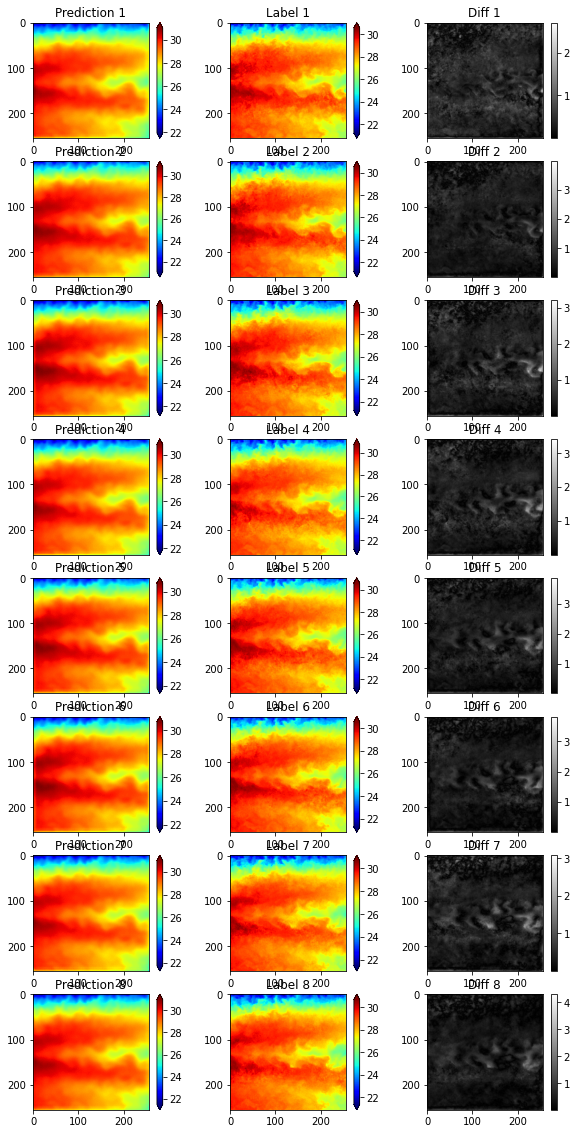

In [19]:
plt.figure(figsize=(10,20))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet')
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet')
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray')
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
